## Speedup & performance evaluation

* TODO: evaluate the speedup & performance of tinyllama model after AWQ quantization

* add visualization for README doc

### Performance

* Use `lm-evaluation-harness` package to evaluate

    `!pip install git+https://github.com/EleutherAI/lm-evaluation-harness.git@big-refactor`

In [9]:
!lm_eval \
    --model hf \
    --model_args pretrained=TinyLlama/TinyLlama-1.1B-Chat-v1.0,dtype="float" \
    --tasks hellaswag,openbookqa,winogrande,arc_easy,arc_challenge,boolq \
    --output evaluation/TinyLlama/ \
    --device cuda:0 --batch_size 32

hf (pretrained=TinyLlama/TinyLlama-1.1B-Chat-v1.0,dtype=float), gen_kwargs: (), limit: None, num_fewshot: None, batch_size: 32
|    Tasks    |Version|Filter|n-shot| Metric |Value |   |Stderr|
|-------------|-------|------|-----:|--------|-----:|---|-----:|
|arc_challenge|Yaml   |none  |     0|acc     |0.2995|±  |0.0134|
|             |       |none  |     0|acc_norm|0.3285|±  |0.0137|
|arc_easy     |Yaml   |none  |     0|acc     |0.6132|±  |0.0100|
|             |       |none  |     0|acc_norm|0.5434|±  |0.0102|
|boolq        |Yaml   |none  |     0|acc     |0.6116|±  |0.0085|
|hellaswag    |Yaml   |none  |     0|acc     |0.4659|±  |0.0050|
|             |       |none  |     0|acc_norm|0.6044|±  |0.0049|
|openbookqa   |Yaml   |none  |     0|acc     |0.2520|±  |0.0194|
|             |       |none  |     0|acc_norm|0.3720|±  |0.0216|
|winogrande   |Yaml   |none  |     0|acc     |0.6038|±  |0.0137|



2024-05-13:23:58:42,393 INFO     [utils.py:148] Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-05-13:23:58:42,393 INFO     [utils.py:161] NumExpr defaulting to 8 threads.
2024-05-13:23:58:42,614 INFO     [config.py:58] PyTorch version 2.3.0+cu121 available.
2024-05-13:23:58:42,615 INFO     [config.py:70] Polars version 0.20.23 available.
2024-05-13:23:58:46,132 INFO     [__main__.py:132] Verbosity set to INFO
2024-05-13:23:58:53,457 INFO     [__main__.py:205] Selected Tasks: ['arc_challenge', 'arc_easy', 'boolq', 'hellaswag', 'openbookqa', 'winogrande']
2024-05-13:23:58:53,461 WARNING  [evaluator.py:93] generation_kwargs specified through cli, these settings will be used over set parameters in yaml tasks.
2024-05-13:23:58:53,511 INFO     [huggingface.py:120] Using device 'cuda:0'
C:\Users\user\anaconda3\envs\hf\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be remove

In [10]:
!lm_eval \
    --model hf \
    --model_args pretrained=tctsung/TinyLlama-1.1B-chat-v1.0-awq \
    --tasks hellaswag,openbookqa,winogrande,arc_easy,arc_challenge,boolq \
    --output evaluation/TinyLlama_AWQ/ \
    --device cuda:0 --batch_size 32

hf (pretrained=tctsung/TinyLlama-1.1B-chat-v1.0-awq), gen_kwargs: (), limit: None, num_fewshot: None, batch_size: 32
|    Tasks    |Version|Filter|n-shot| Metric |Value |   |Stderr|
|-------------|-------|------|-----:|--------|-----:|---|-----:|
|arc_challenge|Yaml   |none  |     0|acc     |0.2969|±  |0.0134|
|             |       |none  |     0|acc_norm|0.3217|±  |0.0137|
|arc_easy     |Yaml   |none  |     0|acc     |0.6086|±  |0.0100|
|             |       |none  |     0|acc_norm|0.5429|±  |0.0102|
|boolq        |Yaml   |none  |     0|acc     |0.6306|±  |0.0084|
|hellaswag    |Yaml   |none  |     0|acc     |0.4559|±  |0.0050|
|             |       |none  |     0|acc_norm|0.5979|±  |0.0049|
|openbookqa   |Yaml   |none  |     0|acc     |0.2560|±  |0.0195|
|             |       |none  |     0|acc_norm|0.3600|±  |0.0215|
|winogrande   |Yaml   |none  |     0|acc     |0.5983|±  |0.0138|



2024-05-14:00:39:45,739 INFO     [utils.py:148] Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-05-14:00:39:45,739 INFO     [utils.py:161] NumExpr defaulting to 8 threads.
2024-05-14:00:39:45,958 INFO     [config.py:58] PyTorch version 2.3.0+cu121 available.
2024-05-14:00:39:45,959 INFO     [config.py:70] Polars version 0.20.23 available.
2024-05-14:00:39:49,426 INFO     [__main__.py:132] Verbosity set to INFO
2024-05-14:00:39:56,616 INFO     [__main__.py:205] Selected Tasks: ['arc_challenge', 'arc_easy', 'boolq', 'hellaswag', 'openbookqa', 'winogrande']
2024-05-14:00:39:56,619 WARNING  [evaluator.py:93] generation_kwargs specified through cli, these settings will be used over set parameters in yaml tasks.
2024-05-14:00:39:56,736 INFO     [huggingface.py:120] Using device 'cuda:0'
C:\Users\user\anaconda3\envs\hf\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be remove

### Speed

In [54]:
# load speed evaluation output data from speed_eval.py
import pandas as pd
import seaborn as sns
ori_speed = pd.read_csv("evaluation/TinyLlama/TinyLlama-1.1B-chat-v1.0_speed.csv")
awq_speed = pd.read_csv("evaluation/TinyLlama_AWQ/TinyLlama-1.1B-chat-v1.0-awq_speed.csv")

In [132]:
# combine token_per_sec of ori_speed and awq_speed into 1 dataframe
import numpy as np
speed_data = pd.DataFrame({
    "TinyLlama": ori_speed['token_per_sec'],
    "Tinyllama-AWQ": awq_speed['token_per_sec']
} 
)
speed_data = speed_data.melt(
    var_name = "Model",
    value_name="token_per_sec"
)
speed_data.head()

,Model,token_per_sec
0,TinyLlama,77.118083
1,TinyLlama,87.909427
2,TinyLlama,89.667286
3,TinyLlama,88.407320
4,TinyLlama,87.945744


In [150]:
np.mean(awq_speed['token_per_sec']) / np.mean(ori_speed['token_per_sec'])

1.6214152737890628

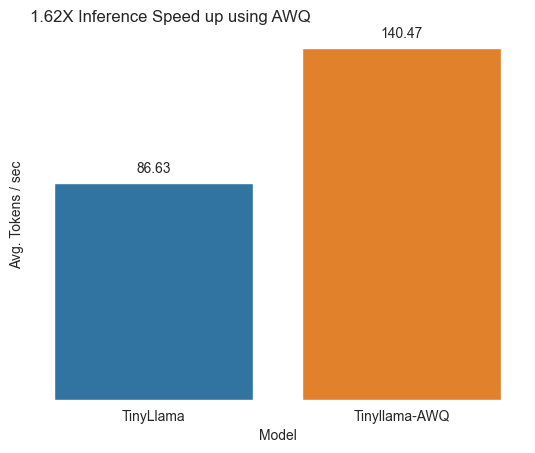

In [166]:
from matplotlib import pyplot as plt

ax = sns.barplot(x='Model', y='token_per_sec', data=speed_data, hue='Model', errorbar=None)
# errorbar="sd", capsize=.3, zorder=5
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
# plt.gca().axes.yaxis.set_visible(False)
ax.yaxis.set_ticks([])
ax.yaxis.set_ticklabels([])
plt.title('1.62X Inference Speed up using AWQ', loc='left')
plt.xlabel('Model')
plt.ylabel('Avg. Tokens / sec')
sns.despine(bottom = True, left = True)

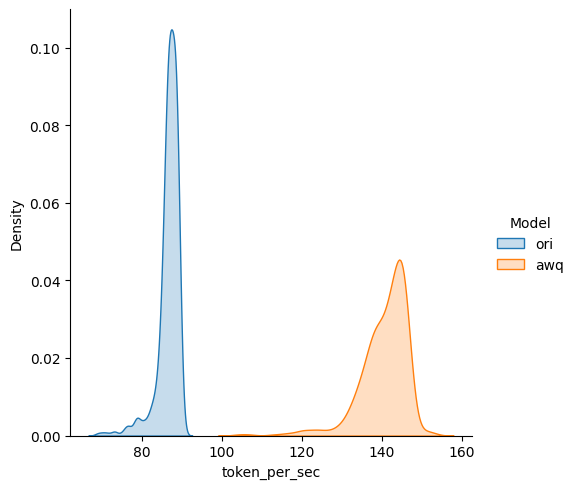

In [77]:
sns.displot(x='token_per_sec', hue = 'Model', fill = 'Model', data=speed_data, kind="kde")

## Memory footprint